# **Assessment 1**

For our first assessment, our goal is to solve an imputation problem: we will create a neural network architecture that learns how to recover missing portions of an image.

This is an important problem in magnetic resonance imaging (MRI), where patient scans are often limited to a few areas to avoid lengthy scanning times.

In particular, we are going to focus on images of human heads. We have managed to gain access to one hundred images of patient's heads but, unfortunately, these images have a significant portion of missing information. Your goal during the assessment is to design a neural network that can recover these missing portions.

<br>

---

<br>

We do not have access to the labels for the images we want to recover, so we will have to be a bit creative to obtain a workable dataset on which to train our neural network.

Fortunately for us, we have access to a generative model that has been trained to produce realistic-looking MRI images of patient's heads. Using this model, you will create an appropriate dataset to train your architecture. We have provided you with the basic setup code to start using this generative model in **Question 1** below.

The corrupted images that we want to recover are contained in the numpy file `test_set.npy` of this repository. The file contains 100 patient images with a size of 64x64 pixels.

The architecture that you design in this assessment should use the artificially-generated dataset in order to recover the missing information in the images contained in `test_set.npy`.

<br>

All answers to the assessment should be contained within the structure below, but you are free to add new code and text cells as required to your answers. Read the text for each question and follow the instructions carefully. Answers that do not follow this structure will not be marked. **Do NOT change the name of this file.**

Please, **make sure to execute all your cells and save the result of the execution**. We will only mark cells that have been executed and will not execute any cells ourselves.

<br>

---

<br>

<br><br>

## **Question 1**  (25%)

Using the provided image-generation network, create a dataset of brain images that will later be used to train your chosen architecture.

Given that you will likely want to use this dataset multiple times during training, we recommend that you save the generated images to an appropriate folder in your GDrive.

Once you have generated your dataset, load and display ten of your generated images here.

We have also provided you with some corrupted images in the file `test_set.npy` of this repository. You should also load and display ten of these corrupted images here.

Below, we have provided template code, including some required downloads and installations, so that you can easily use the trained generative model. Sample generation in this model is done using the function `generate`, and is controlled by some input arguments. It is your job to figure out a sensible set of parameters that will produce images that are useful for the requirements of your task.

<br>

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [2]:
import os
import sys
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torchvision.transforms import Compose, Lambda, ToTensor, Normalize
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
! pip install livelossplot
from livelossplot import PlotLosses

In [3]:
# This code was taken from the lecture 3 notes

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True


def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

Cuda installed! Running on GPU 0 NVIDIA L4!


In [4]:
# Pull and install necessary files
from google.colab import drive
drive.mount('/content/drive')

# INSTRUCTIONS:
# Open in a BROWSER https://drive.google.com/file/d/1I8Ry7Z_QqnlARwOuDgN4NPCd-GcLw1OC/view?usp=drive_link
# Download the file cw1_files.zip
# Go to https://drive.google.com/ and log in with the account you will be using for this coursework
# In the folder 'My Drive' upload cw1_files.zip (DO NOT UNZIP THE FILE)
# Run the following:

!unzip /content/drive/MyDrive/cw1_files.zip -d ./
!chmod +x run.sh
!bash ./run.sh
sys.path.append('/content/ese-invldm')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/cw1_files.zip
  inflating: ./files/config_training.yml  
  inflating: ./run.sh                
  inflating: ./ese-invldm/setup.py   
  inflating: ./files/default_config.yml  
  inflating: ./ese-invldm/ese_invldm/ese_invldm.py  
  inflating: ./ese-invldm/ese_invldm/__init__.py  
  inflating: ./files/autoencoder/autoencoder_ckpt_latest.pth  
  inflating: ./files/diffusion/diffusion_ckpt_latest.pth  
Cloning the repository from https://github.com/dpelacani/InverseLDM.git...
Cloning into 'InverseLDM'...
remote: Enumerating objects: 1331, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 1331 (delta 167), reused 182 (delta 100), pack-reused 1070 (from 1)
Receiving objects: 100% (1331/1331), 467.16 KiB | 1.82 MiB/s, done.
Resolving deltas: 100% (875/875), done.
  P

In [5]:
from ese_invldm import generate

"""
Generates samples using a diffusion-based generative model.

This function leverages a pre-configured diffusion model to produce synthetic samples.
The sampling process supports adjustable parameters for total samples, inference steps, and batch size.
A scheduler and temperature can also be configured to control the sampling behaviour.

Parameters:
    num_samples (int):
        Total number of samples to generate.
    num_inference_steps (int):
        Number of diffusion inference steps.
        The minimum number of steps is 1, but we recommend exploring the range from 10 to 50.
        Please note that more steps will increase quality but also the computational cost. Be careful not
        to burn through your credits by using a very large number of steps!
    batch_size (int):
        Number of samples to process in each batch during sampling.
    scheduler (str, optional):
        Sampling scheduler to use (e.g., "ddim", "ddpm"). You can quickly test which one provides the most appropriate results
        for this task.
    temperature (float, optional):
        Sampling temperature to control randomness, given as a number between 0 and 1. Higher values produce more diverse outputs.
    seed (int, optional):
        Random seed for reproducibility. Defaults to 42.

Returns:
    list:
        A list containing the batches of generated samples, where each sample
        corresponds to a single data instance produced by the diffusion model.

"""

sample1 = generate(num_samples = 1, num_inference_steps = 10, batch_size = 1, scheduler = "ddim", temperature = 0.5, seed = 42)
sample2 = generate(num_samples = 1, num_inference_steps = 10, batch_size = 1, scheduler = "ddpm", temperature = 0.5, seed = 42)

sample3 = generate(num_samples = 1, num_inference_steps = 10, batch_size = 1, scheduler = "ddim", temperature = 0.5, seed = 42)
sample4 = generate(num_samples = 1, num_inference_steps = 50, batch_size = 1, scheduler = "ddim", temperature = 0.5, seed = 42)





/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/usr/local/lib/python3.10/dist-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/content/InverseLDM/invldm/runners/base_runner.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. T

Batch 0


100%|██████████| 10/10 [00:00<00:00, 11.47it/s]


Batch 0


100%|██████████| 10/10 [00:00<00:00, 29.94it/s]


Batch 0


100%|██████████| 10/10 [00:00<00:00, 34.75it/s]


Batch 0


100%|██████████| 50/50 [00:01<00:00, 35.05it/s]


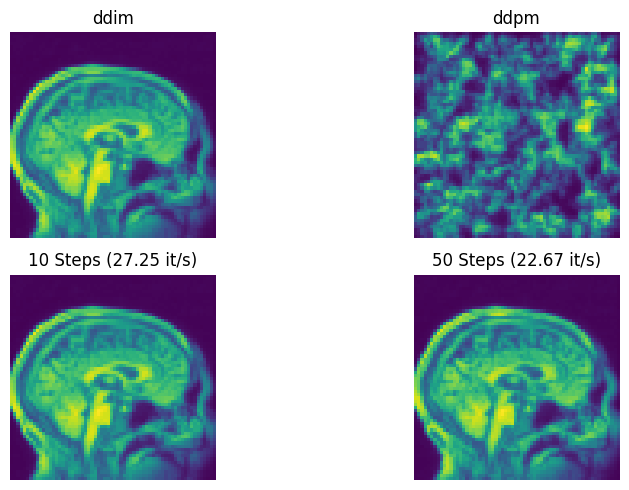

In [6]:
## Compare samples

sample1_img = sample1[0].type(torch.float32)
sample2_img = sample2[0].type(torch.float32)
sample3_img = sample3[0].type(torch.float32)
sample4_img = sample4[0].type(torch.float32)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the the two scheduler methods
axes[0][0].imshow(sample1_img.squeeze(0).squeeze(0).cpu())
axes[0][0].set_title("ddim")
axes[0][0].axis("off")

axes[0][1].imshow(sample2_img.squeeze(0).squeeze(0).cpu())
axes[0][1].set_title("ddpm")
axes[0][1].axis("off")

# Plot 2 levels of Inference steps
axes[1][0].imshow(sample3_img.squeeze(0).squeeze(0).cpu())
axes[1][0].set_title("10 Steps (27.25 it/s)")
axes[1][0].axis("off")

axes[1][1].imshow(sample4_img.squeeze(0).squeeze(0).cpu())
axes[1][1].set_title("50 Steps (22.67 it/s)")
axes[1][1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

## - Not a hugely noticable step in detail between 10 and 50 so I chose 30 as a tradeoff between detail and computation.

## - ddim is clearly the better scheduler so we will use that

## - We want a decent level of variety in our dataset but too high a temp can cause some large abormalities in the dataset which will introduce noise into our model so we will go with temp = 0.5

In [265]:
## Now lets download out data
num_samples = 10000
num_inference_steps = 30
batch_size = 64

data = generate(num_samples = num_samples, num_inference_steps = num_inference_steps, batch_size = batch_size, scheduler = "ddim", temperature = 0.5, seed = 42)

/content/InverseLDM/invldm/runners/base_runner.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_states = torch.load(path)


Batch 0


100%|██████████| 30/30 [00:03<00:00,  8.23it/s]


Batch 1


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 2


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 3


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 4


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 5


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 6


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 7


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 8


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 9


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 10


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 11


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 12


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Batch 13


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 14


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 15


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 16


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 17


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 18


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 19


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 20


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Batch 21


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 22


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Batch 23


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 24


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 25


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 26


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 27


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 28


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 29


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 30


100%|██████████| 30/30 [00:03<00:00,  8.25it/s]


Batch 31


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 32


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 33


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 34


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 35


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 36


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 37


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 38


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 39


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 40


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 41


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 42


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 43


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 44


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 45


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 46


100%|██████████| 30/30 [00:03<00:00,  8.24it/s]


Batch 47


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 48


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 49


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 50


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 51


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 52


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 53


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 54


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 55


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 56


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 57


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 58


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 59


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 60


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 61


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 62


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 63


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 64


100%|██████████| 30/30 [00:03<00:00,  8.31it/s]


Batch 65


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 66


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 67


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 68


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 69


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 70


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 71


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 72


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 73


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 74


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 75


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 76


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 77


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 78


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 79


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 80


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 81


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 82


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 83


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 84


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 85


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 86


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 87


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 88


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 89


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Batch 90


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 91


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 92


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 93


100%|██████████| 30/30 [00:03<00:00,  8.25it/s]


Batch 94


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 95


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Batch 96


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 97


100%|██████████| 30/30 [00:03<00:00,  8.27it/s]


Batch 98


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 99


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 100


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Batch 101


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 102


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 103


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 104


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 105


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 106


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Batch 107


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 108


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 109


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 110


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 111


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 112


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 113


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 114


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 115


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 116


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 117


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 118


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 119


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 120


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 121


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 122


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 123


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 124


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 125


100%|██████████| 30/30 [00:03<00:00,  8.25it/s]


Batch 126


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 127


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 128


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 129


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 130


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 131


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 132


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 133


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 134


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 135


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 136


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 137


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 138


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 139


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 140


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 141


100%|██████████| 30/30 [00:03<00:00,  8.25it/s]


Batch 142


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 143


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 144


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 145


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 146


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 147


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 148


100%|██████████| 30/30 [00:03<00:00,  8.28it/s]


Batch 149


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 150


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 151


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 152


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 153


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 154


100%|██████████| 30/30 [00:03<00:00,  8.30it/s]


Batch 155


100%|██████████| 30/30 [00:03<00:00,  8.29it/s]


Batch 156


100%|██████████| 30/30 [00:01<00:00, 25.37it/s]


In [57]:
## Check data shape
data[0].shape

torch.Size([64, 1, 64, 64])

## For this task I have chosen to download my data in batches of 64 as it means I can download a larger dataset faster. My thinking is that more data will produce a better model. I have downloaded 10,000 samples, twice for a total of 20,000 samples. I feel for a dataset like brain scan imagery where there is not a large amount of variation between the heads that 10,000+ should be more than enough data to acheive good results.

In [266]:
# Code to save generated image data to a local file, this is key for efficient memory usage

# Path to save the files
save_directory = "/content/drive/MyDrive/DL_CW_Data/Brains"
os.makedirs(save_directory, exist_ok=True)

# Save each batch in a folder
for i, batch in enumerate(data):
    # Convert to numpy for saving
    batch_numpy = batch.cpu().numpy()
    # Save as an .npy file
    np.save(os.path.join(save_directory, f"batch_{i}.npy"), batch_numpy)


## Below I have implemented a script to check for any incomplete batches of data. This is important as sinced my data is batched, incompleteness in some batches will cause issues when calling the __getitem__() method of my custom Dataset class

In [7]:
## This code was written with help from chat GPT
def check_array_shapes(folder_path, min_dim_threshold):

    invalid_files = []
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.npy')]

    for idx, file_name in enumerate(file_list):
        file_path = os.path.join(folder_path, file_name)

        try:
            # Load the numpy array
            array = np.load(file_path)
            # Check if any dimension is below the threshold
            if array.shape[0] < 64:
                print(f"Invalid shape in file {file_name}: {array.shape}")
                invalid_files.append(idx)
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    return invalid_files

save_directory = "/content/drive/MyDrive/DL_CW_Data/Brains"

check_array_shapes(save_directory, 64)

# if the last file is not full this is ok, if any intermediate files are unfull this needs to be ammended


Invalid shape in file batch_329.npy: (16, 1, 64, 64)


[328]

## Display 10 generated images

### As we can see our generated images have a good level of variety ewithout being too unrealistically disfigured.

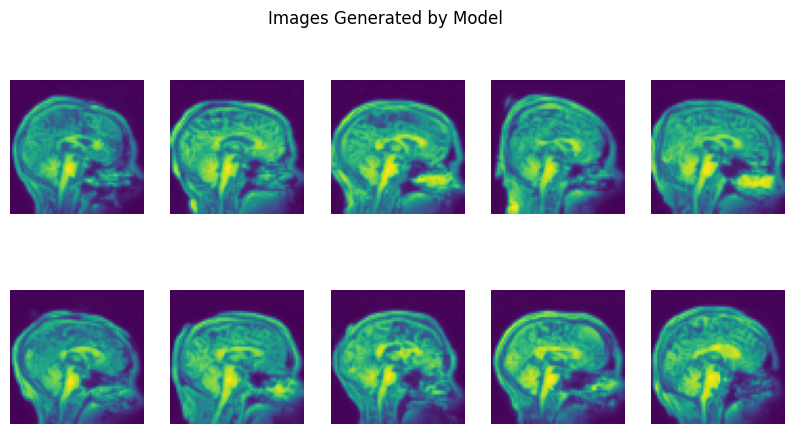

In [10]:


file_path = f"/content/drive/MyDrive/DL_CW_Data/Brains/batch_20.npy"
imgs = np.load(file_path)[:10]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 1 row, 2 columns

plt.suptitle("Images Generated by Model")
img_index = 0
for i in [0,1]:
  for j in range(5):
    # Plot the the two scheduler methods
    axes[i][j].imshow(imgs[img_index].squeeze(0))
    axes[i][j].axis("off")
    img_index += 1







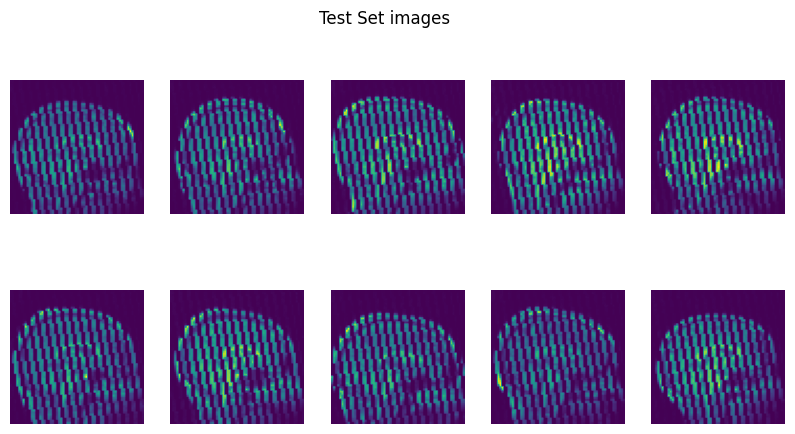

In [19]:
## Open .npy file and examine brain images

file_path = "/content/drive/MyDrive/DL_CW_Data/Brains/test_set.npy"
real_imgs = np.load(file_path)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 1 row, 2 columns

plt.suptitle("Test Set images")
img_index = 0
for i in [0,1]:
  for j in range(5):
    # Plot the the two scheduler methods
    axes[i][j].imshow(real_imgs[img_index].squeeze(0))
    axes[i][j].axis("off")
    img_index += 1

<br>

---

<br>

## **Question 2**  (25%)

Using the data generated in **Question 1**, create a PyTorch `TensorDataset` and a `DataLoader` for the training set.

Using the provided corrupted images inside `test_set.npy`, create another `TensorDataset` and a `DataLoader` for the test set.

The training dataset should provide batches of brain images generated in **Question 1** and should corrupt these images appropriately so that they resemble images in the test set. The dataset should also pair each image with its corresponding un-corrupted image as a label.

The test dataset should provide the corrupted images provided, for which no labels are available.

Display here ten images of your training dataset and ten images of your test dataset, and their corresponding labels when available.

<br>



## Below is my custom datset model, It's functionalities include: the ability to select which split of the dataset you would like, the train and validation splits return a proportion of the generated dataset which can be controlled via the train_val_ratio variable. You can also choose the proportion of the datast you want to use through the use_proportion varaible, this is for if you want to quickly bench mark a model on a small amount of data.

In [23]:
num_samples = 512
num_inference_steps = 30
batch_size = 64

class BrainsDataset(Dataset):

  def __init__(self, root, train_val_ratio = 0.2, split='train', use_proportion = 1, transform=None):
        self.transform = transform
        self.split = split
        self.train_val_ratio = train_val_ratio
        self.use_proportion = use_proportion

        # Set simple transform if transform not explicitly sey
        if transform is None:
          self.transform = transforms.Compose([])

        if split == 'train' or split == 'validation':
          #print(f"Initialised data set in {self.split} mode")
          self.root = root
        elif split == 'test':
          #print("Initialised data set in test mode")
          self.root = f"{root}/test_set.npy"
          #print("root",self.root)
        else:
          raise ValueError(f"Invalid split: {split}. Expected 'train' or 'test'.")

        self._total_file_count = self._total_files()

  def _get_mask(self):

    im = np.load(f"{self.root}/test_set.npy")[0]
    #print("im:",im)

    # Create mask from data
    zero_vals = (im == 0)
    im[zero_vals] = 1
    im[~zero_vals] = 0

    return torch.tensor(im)


  def __getitem__(self, idx):

    #print("calling __getitem__()")

    if self.split == 'train' or self.split == 'validation':
      # Calculate how many indices belong to train and val
      #print("total img count", self._total_file_count)
      train_idx_max = int((1 - self.train_val_ratio) * (self._total_file_count - 1))
      #print("max train idx",train_idx_max)
      val_idx_max = (self._total_file_count - 1) - train_idx_max - 1 # -1 for the test_files
      #print("max val idx", val_idx_max)



      if self.split == 'train':
          if idx > train_idx_max:
            raise IndexError(f"Index out of range, max index: {train_idx_max}")

          # Batches of 64, load in the corresponding image
          batch_number = int((idx) / batch_size)
          #print("batch number:\n", batch_number)
          file_path = f"{self.root}/batch_{batch_number + 1}.npy"
          batch = torch.from_numpy(np.load(file_path))  # Load batch as a tensor
          # Convert mask to numpy or batch to tensor for consistency

          return self.transform(batch[idx % batch_size] * self._get_mask()), self.transform(batch[idx % batch_size])

      elif self.split == 'validation':
          if idx > val_idx_max:
            raise IndexError(f"Index out of range, max index: {val_idx_max}")

          # Batches of 64, load in the corresponding image
          batch_number = int((idx + train_idx_max) / batch_size)
          #print("batch number:\n", batch_number)
          file_path = f"{self.root}/batch_{batch_number + 1}.npy"
          batch = torch.from_numpy(np.load(file_path)) # Load batch as a tensor

          # Convert mask to numpy or batch to tensor for consistency
          return self.transform(batch[(idx + train_idx_max) % batch_size] * self._get_mask()), self.transform(batch[(idx + train_idx_max) % batch_size])

    elif self.split == 'test':
      # real image file quite small so can be brough onto memory all at once
      real_imgs = np.load(self.root)
      return self.transform(torch.from_numpy(real_imgs[idx]))

    else:
      raise ValueError(f"Invalid split: {self.split}. Expected 'train' 'validation' or 'test'.")


  def _total_files(self):

    if self.split in ["train", "validation"]:
      files = os.listdir(self.root)
      # Find out how many files in the image folder
      no_files = len([f for f in files if os.path.isfile(os.path.join(self.root, f))])
      # Find out how many images in the last file dont forget the test_set.npz
      imgs_in_last = np.load(f"{self.root}/batch_{no_files - 1}.npy").shape[0]
      no_ims = (((no_files - 1 - 1) * batch_size + imgs_in_last))
      print("total files", no_ims)
      return no_ims


  def __len__(self):

    #print("calling __len__()")

    if self.split in ["train", "validation"]:

      files = os.listdir(self.root)
      # Find out how many files in the image folder
      no_files = len([f for f in files if os.path.isfile(os.path.join(self.root, f))])
      # Find out how many images in the last file dont forget the test_set.npz
      imgs_in_last = np.load(f"{self.root}/batch_{no_files - 1}.npy").shape[0]
      #print(no_files, imgs_in_last)


      if self.split == "train":
        # Extra -1 to account for the extra test_set.npz file now in the folder
        return int(self.use_proportion * ((no_files - 1 - 1) * batch_size + imgs_in_last) * (1 - self.train_val_ratio))

      elif self.split == "validation":
        return int(self.use_proportion * ((no_files - 1 - 1) * batch_size + imgs_in_last) * (self.train_val_ratio))

    elif self.split == 'test':

      return np.load(f"{self.root}").shape[0]

    else:
      raise ValueError(f"Invalid split: {self.split}. Expected 'train', 'validation' or 'test'.")









In [24]:
train_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", split = "train", )
valid_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", split = "validation")
test_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", split = "test")

total files 21008
total files 21008


In [25]:
# Testing dataset object

train_dataset[0]
print(f"length of train {len(train_dataset)}")
print(train_dataset[8000][0].shape)
#train_dataset[1000]

valid_dataset[0]
print(len(valid_dataset))
print(valid_dataset[2000][0].shape)
#valid_dataset[100]

test_dataset[0]
print(len(test_dataset))
print(test_dataset[99].shape)
#test_dataset[100]


length of train 16806
torch.Size([1, 64, 64])
4201
torch.Size([1, 64, 64])
100
torch.Size([1, 64, 64])


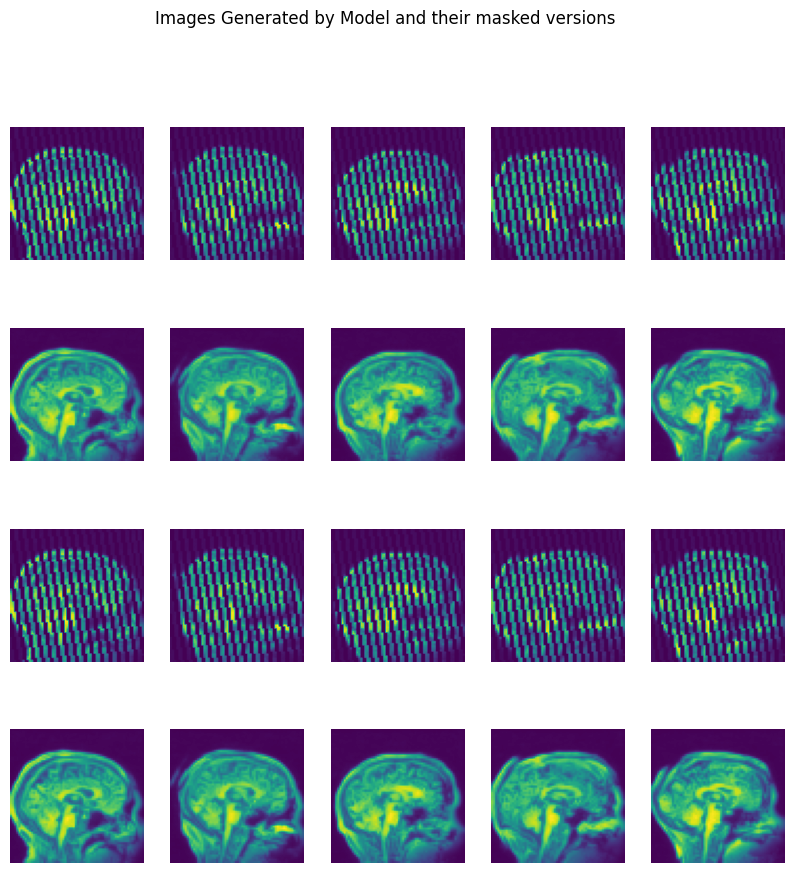

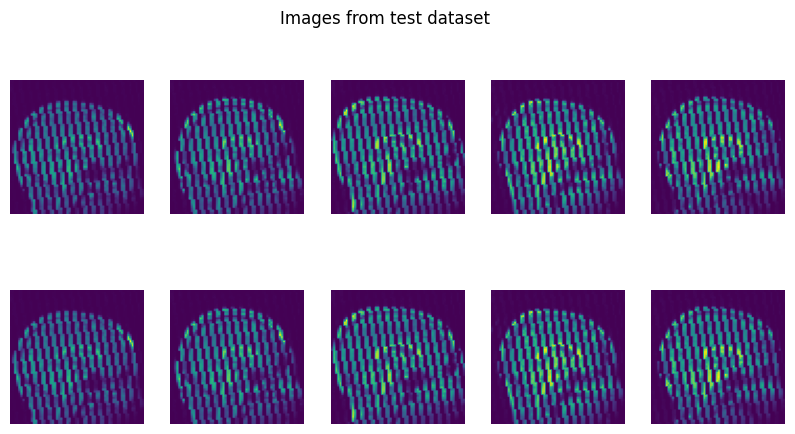

In [26]:

fig, axes = plt.subplots(4, 5, figsize=(10, 10))  # 1 row, 2 columns

plt.suptitle("Images Generated by Model and their masked versions")
img_index = 0


for j in [0,2]:
  for i in range(5):
    # Plot the generated images
    axes[j][i].imshow(train_dataset[i][0].squeeze(0))
    axes[j][i].axis("off")
    # Plot the masked generated images
    axes[j+1][i].imshow(train_dataset[i][1].squeeze(0))
    axes[j+1][i].axis("off")


fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 1 row, 2 columns

plt.suptitle("Images from test dataset")
img_index = 0

for j in [0,1]:
  for i in range(5):
    # Plot the generated images
    axes[j][i].imshow(test_dataset[i].squeeze(0))
    axes[j][i].axis("off")





<br>

---

<br>

## **Question 3** (50%)

Using the dataset created in **Question 2**, design and train an architecture to recover the missing image lines of the provided test dataset.

Once you have trained your architecture, display here ten images of the test set with the recovered lines filled in.

Additionally, save the test data with the missing values filled in into a numpy file called `test_set_nogaps.npy`. These images should be **in the same order** as those in the `test_set.npy` file and should have the same pixel size of 64x64. **Any images not contained in the `test_set_nogaps.npy` file or incorrectly ordered will not be marked.**

You have freedom to choose an architecture that you consider appropriate to solve this problem. However, you will need to train your chosen architecture as part of the assessment: **pre-trained networks are not allowed**.

You will be assessed by the quality of your predictions of the missing data values and additional marks will be given for originality in your network design choices. You should include, as part of your answer, a paragraph explaining the architecture you have chosen and any additional design choices and hyperparameters that have been important to build your solution.

This is an open-book assessment and you are encouraged to use resources online, including  tools like chatGPT. However, make sure to always mention the sources for your code and ideas, including websites, papers, and tools like chatGPT.

<br>


## Below I have calculated some statistics of the dataset that so I can use them for normalisation transforms.

In [153]:
# Caclulate statistics of whole dataset

# This code was written with help flrom chat GPT

# Initialize accumulators
total_sum = 0  # Scalar for mean calculation
total_count = 0  # Scalar for counting total elements
overall_min = float('inf')  # Scalar for global min
overall_max = float('-inf')  # Scalar for global max

# Iterate through batches
for batch in train_dataloader:
    total_sum += batch[1].sum().item()  # Sum all elements in the batch
    total_count += batch[1].numel()  # Count total elements in the batch
    overall_min = min(overall_min, batch[1].min().item())  # Update global min
    overall_max = max(overall_max, batch[1].max().item())  # Update global max

# Calculate overall mean
overall_mean = total_sum / total_count

print("Overall Mean:", overall_mean)
print("Overall Min:", overall_min)
print("Overall Max:", overall_max)

Overall Mean: 0.19083353413085383
Overall Min: 0.0078887939453125
Overall Max: 0.72412109375


In [156]:
# calculate the std of the dataset

sum_of_squared_diffs = 0

for batch in train_dataloader:
    data = batch[1]
    sum_of_squared_diffs += ((data - overall_mean) ** 2).sum().item()  # Sum squared differences

# Calculate standard deviation
overall_std = (sum_of_squared_diffs / total_count) ** 0.5

print("Overall Std:", overall_std)

Overall Std: 0.1430658504061804


In [6]:
over_all_mean = 0.19083442000226783
over_all_min = 0.0078887939453125
over_all_max = 0.72412109375
overall_std = 0.1430658504061804

In [204]:
# Re Initialise datasets with transforms

transform= transforms.Compose([
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.Normalize((over_all_mean,), (overall_std,)),
    ])

train_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", transform = transform, train_val_ratio = 0.2)
valid_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", transform = transform, split = "validation", train_val_ratio = 0.2)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

total files 11024
total files 11024


## Below is the model I will be testing, I have chosen to go with UNET

In [12]:
## UNET, Taken from Lecture 8 Notes
import torch.nn.functional as F

# Define a convolutional block
class ConvBlock(nn.Module):
    """time-conditioned convolutional block"""

    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias = True)
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.LeakyReLU()  # Change to relu
        #self.dropout = nn.Dropout2d(0.3)  # Apply dropout after activation

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        #x = self.dropout(x)
        return x

# define an encoder block of the U-Net with time-embedding
class EncBlock(nn.Module):
    """time-conditioned U-Net encoder block"""

    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv_block1 = ConvBlock(in_c, out_c)
        self.conv_block2 = ConvBlock(out_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, x):
        h = self.conv_block1(x)
        h = self.conv_block2(h)
        p = self.pool(h)
        return h, p

# define an decoder block of the U-Net with time-embedding
class DecBlock(nn.Module):
    """time-conditioned U-Net decoder block"""

    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv_block1 = ConvBlock(out_c+out_c, out_c)
        self.conv_block2 = ConvBlock(out_c, out_c)

    def forward(self, x, s):
        h = self.up(x)
        h = torch.cat([h, s], axis=1) # concatenate x with U-Net skip connection from encoder
        h = self.conv_block1(h,)
        h = self.conv_block2(h,)
        return h

In [13]:
class Unet(nn.Module):
    """DDPM U-Net, https://arxiv.org/abs/2006.11239 and https://arxiv.org/abs/1505.04597"""

    def __init__(self, n_channels):
        super().__init__()



        # encoder
        self.e1 = EncBlock(n_channels, 64)
        self.e2 = EncBlock(64, 128)
        self.e3 = EncBlock(128, 256)
        self.e4 = EncBlock(256, 512)

        # bottleneck
        self.b1 = ConvBlock(512, 1024)
        self.b2 = ConvBlock(1024, 1024)

        # decoder
        self.d1 = DecBlock(1024, 512)
        self.d2 = DecBlock(512, 256)
        self.d3 = DecBlock(256, 128)
        self.d4 = DecBlock(128, 64)

        # output layer
        self.output = nn.Conv2d(64, n_channels, kernel_size=1, padding=0)

    def forward(self, x):



        # encoder
        s1, x = self.e1(x)
        s2, x = self.e2(x)
        s3, x = self.e3(x)
        s4, x = self.e4(x)

        # bottleneck
        x = self.b1(x)
        x = self.b2(x)

        # decoder
        x = self.d1(x, s4)
        x = self.d2(x, s3)
        x = self.d3(x, s2)
        x = self.d4(x, s1)

        # output
        output = self.output(x)

        return output

In [14]:
# Hyperparameters
lr = 1e-4
batch_size = 64
num_workers = 0
wd = 1e-3
nepochs = 30

# define the model and send to the GPU
model = Unet(1).to(device)
# specify the Adam optimizer with a learning rate of 2e-4
optimiser = torch.optim.Adam(model.parameters(), lr=2e-4)
# set the criterion to be the mse loss
criterion = F.mse_loss

# Define a compose container containing some transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.Normalize((over_all_mean,), (overall_std,)),
    ])

train_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", transform = transform, use_proportion=1)
valid_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", transform = transform, split = "validation", use_proportion=1)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

total files 21008
total files 21008


In [11]:
## This code was written with help from chat gpt

# Define training loop with loss plotting and random sample visualization
def train_unet(model, train_loader, val_loader, valid_dataset, optimizer, criterion, device, num_epochs=20,):
    # Move model to device (GPU or CPU)
    model.to(device)

    best_val_loss = float('inf')

    # Initialize the liveloss plot
    liveloss = PlotLosses()

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss (using BCE with logits for binary imputation)
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

        # Average loss for this epoch
        avg_train_loss = train_loss / len(train_loader)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():  # No need to compute gradients during validation
            for batch_idx, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Compute loss (using BCE with logits for binary imputation)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Average validation loss
        avg_val_loss = val_loss / len(val_loader)

        # Print statistics for this epoch
        print(f'Epoch {epoch + 1}/{num_epochs} - '
              f'Train Loss: {avg_train_loss:.4f} - '
              f'Val Loss: {avg_val_loss:.4f}')

        # Update the liveloss plot
        logs = {}
        logs['log loss'] = avg_train_loss
        logs['val_log loss'] = avg_val_loss
        liveloss.update(logs)
        liveloss.draw()

        # Visualize a random validation sample
        valid_sample, valid_target = valid_dataset[torch.randint(0, len(valid_dataset), (1,)).item()]
        output_sample = model(valid_sample.unsqueeze(0).to(device))

        # Plot the sample images
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(valid_sample[0].cpu(), cmap="gray")
        axs[0].set_title("Input Sample")
        axs[0].axis('off')

        axs[1].imshow(valid_target[0].cpu(), cmap="gray")
        axs[1].set_title("Ground Truth")
        axs[1].axis('off')

        axs[2].imshow(output_sample[0, 0].detach().cpu(), cmap="gray")
        axs[2].set_title("Model Output")
        axs[2].axis('off')

        plt.show()

    print('Training complete.')



## Below are some outputs of my Unet model after being trained on 10K samples





In [243]:
# Save the origonal simple UNET model
torch.save(model.state_dict(), './drive/MyDrive/DL_CW_Data/Models/Simple_UNET_10K_dataset.pt')


<ipython-input-35-a4a29608638e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/DL_CW_Data/Models/Simple_UNET_10K_d

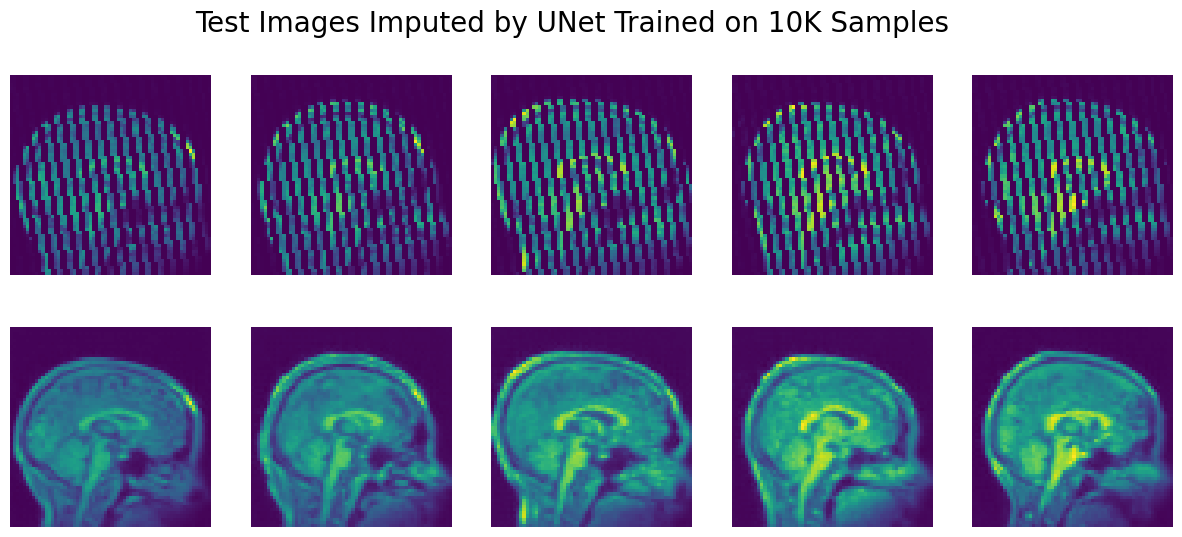

In [35]:
## Testing 10K Unet on Test data

# Load in test data
test_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", transform = transform, split = "test")

## Load in 20K Unet
model = Unet(n_channels=1)
model.load_state_dict(torch.load('/content/drive/MyDrive/DL_CW_Data/Models/Simple_UNET_10K_dataset.pt', map_location=torch.device(device) ))

## Set Model to Eval
model.eval()  # For inference



## Plot side by sides of test data and inference
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Test Images Imputed by UNet Trained on 10K Samples', fontsize=20)

for i in range(5):
  # Plot the test images
  axes[0][i].imshow(test_dataset[i].squeeze(0))
  axes[0][i].axis("off")
  # Plot the generated results
  axes[1][i].imshow(model(test_dataset[i].unsqueeze(0)).detach().squeeze(0).squeeze(0))
  axes[1][i].axis("off")

## Training a Unet on a 20K samples dataset


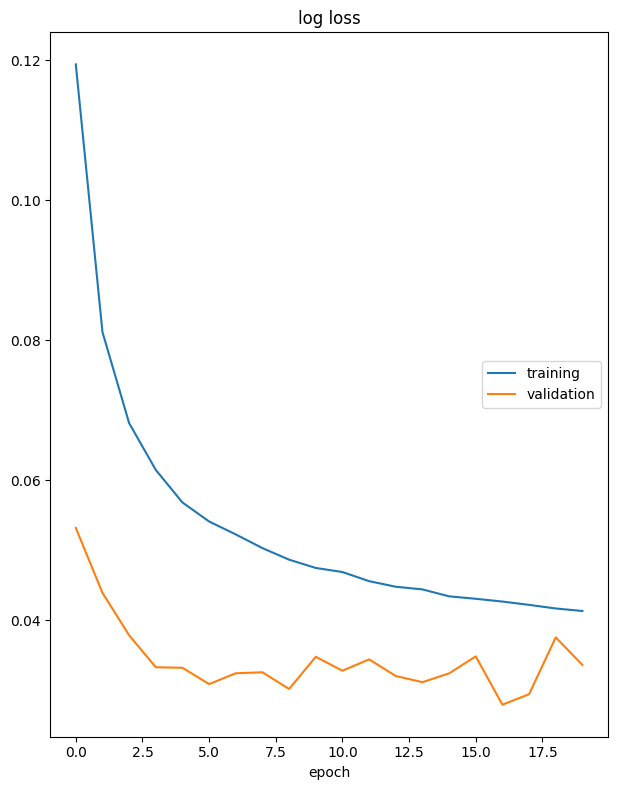

log loss
	training         	 (min:    0.041, max:    0.119, cur:    0.041)
	validation       	 (min:    0.028, max:    0.053, cur:    0.034)


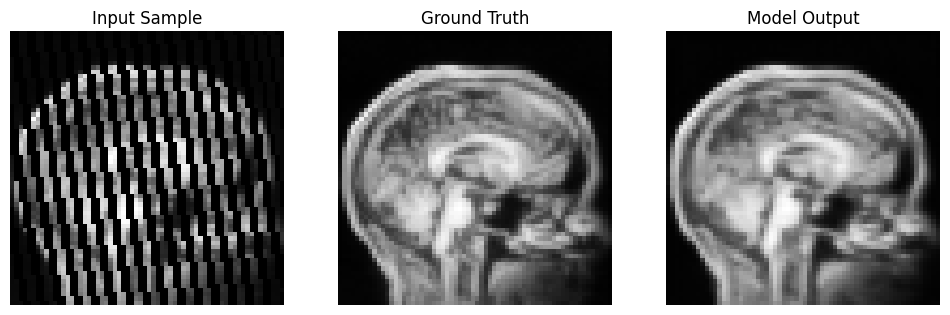

Training complete.


Unet(
  (e1): EncBlock(
    (conv_block1): ConvBlock(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.01)
      (dropout): Dropout2d(p=0.3, inplace=False)
    )
    (conv_block2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.01)
      (dropout): Dropout2d(p=0.3, inplace=False)
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): EncBlock(
    (conv_block1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.01)
      (d

In [283]:
# Train a the UNET with added drop out
lr = 1e-4
optim = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Train model
train_unet(model, train_loader, valid_loader, valid_dataset, optim, criterion, device, num_epochs=20,)

In [285]:
# Save the origonal simple UNET model
torch.save(model.state_dict(), './drive/MyDrive/DL_CW_Data/Models/Simple_UNET_20K_dataset.pt')

<ipython-input-20-1ddea74967d9>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/DL_CW_Data/Models/Simple_UNET_20K_

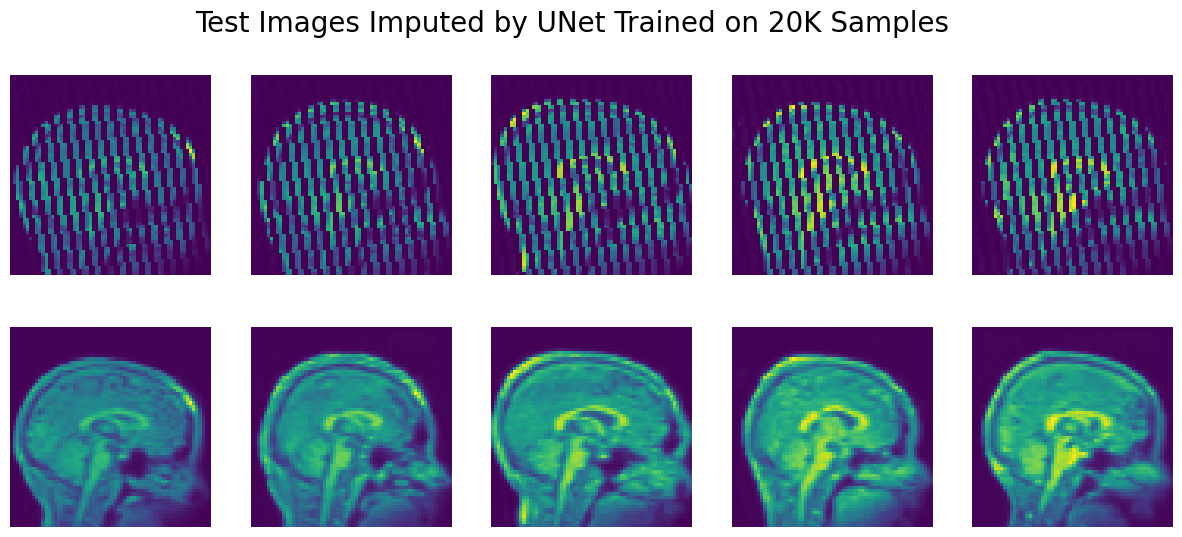

In [20]:
## Testing 20K Unet on Test data

# Define a compose container containing some transforms to increase data diversity
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.Normalize((over_all_mean,), (overall_std,)),
    ])

# Load in test data
test_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", transform = transform, split = "test")

## Load in 20K Unet
model = Unet(n_channels=1)
model.load_state_dict(torch.load('/content/drive/MyDrive/DL_CW_Data/Models/Simple_UNET_20K_dataset.pt',  map_location=torch.device(device)))

## Set Model to Eval
model.eval()  # For inference



## Plot side by sides of test data and inference
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Test Images Imputed by UNet Trained on 20K Samples', fontsize=20)

for i in range(5):
  # Plot the test images
  axes[0][i].imshow(test_dataset[i].squeeze(0))
  axes[0][i].axis("off")
  # Plot the generated results
  axes[1][i].imshow(model(test_dataset[i].unsqueeze(0)).detach().squeeze(0).squeeze(0))
  axes[1][i].axis("off")







## Comparing outputs from the Unet when being trained on both 10K and 20K samples

<br>

---

<br>

<ipython-input-24-a342ccca236c>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_10.load_state_dict(torch.load('/content/drive/MyDrive/DL_CW_Data/Models/Simple_UNET_1

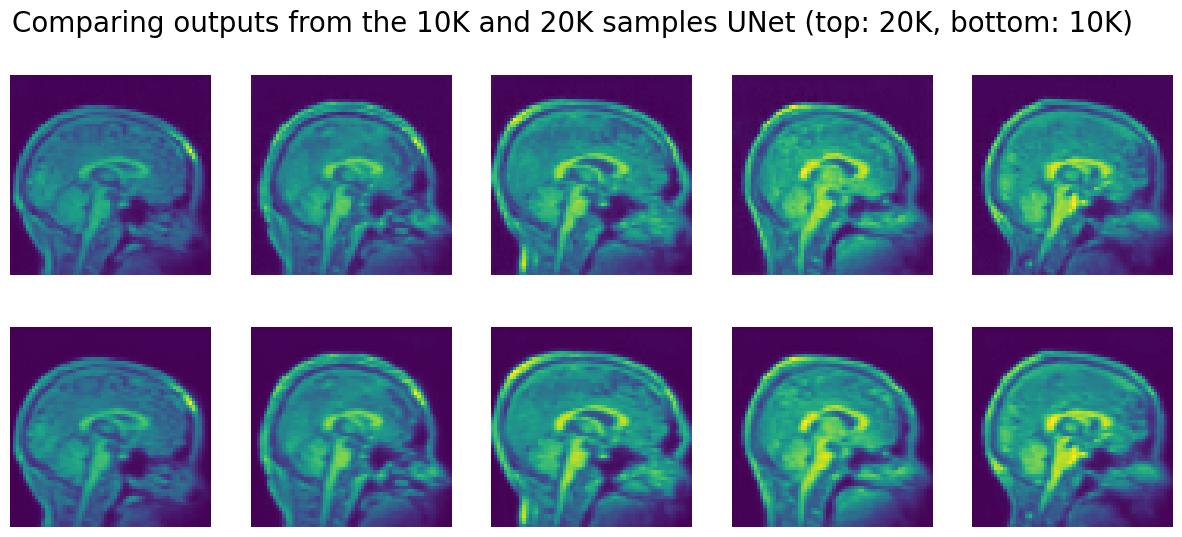

In [24]:
## Plot side by sides of test data and inference
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Comparing outputs from the 10K and 20K samples UNet (top: 20K, bottom: 10K)', fontsize=20)

## Loading in both models

# Load in test data
test_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", transform = transform, split = "test")

## Load in 10K Unet
model_10 = Unet(n_channels=1)
model_10.load_state_dict(torch.load('/content/drive/MyDrive/DL_CW_Data/Models/Simple_UNET_10K_dataset.pt',  map_location=torch.device(device)))


## Load in 20K Unet
model_20 = Unet(n_channels=1)
model_20.load_state_dict(torch.load('/content/drive/MyDrive/DL_CW_Data/Models/Simple_UNET_20K_dataset.pt',  map_location=torch.device(device)))



for i in range(5):
  # Plot the test images
  axes[0][i].imshow(model_10(test_dataset[i].unsqueeze(0)).detach().squeeze(0).squeeze(0))
  axes[0][i].axis("off")
  # Plot the generated results
  axes[1][i].imshow(model_20(test_dataset[i].unsqueeze(0)).detach().squeeze(0).squeeze(0))
  axes[1][i].axis("off")

## Discussion of UNET peformance

###I found that there was not a significant visible difference between the 10K and 20K models.

In [25]:
## This code was written with assistance from chat gpt

## Save all model outputs for test data into a .npy

model_20.eval()
model_20.to(device)

# Load in test data
test_dataset = BrainsDataset(root = "/content/drive/MyDrive/DL_CW_Data/Brains", transform = transform, split = "test")

outputs = []

with torch.no_grad():
    for i, sample in enumerate(test_dataset):

        sample = sample.to(device)
        output = model(sample.unsqueeze(0))

        output = output.squeeze(0)

        # Append the output to the list
        outputs.append(output.cpu().numpy())  # Move to CPU and convert to numpy

# Convert list of outputs to a single numpy array with shape (100, 1, 64, 64)
outputs_array = np.stack(outputs, axis=0)  # Stack along the first axis

# Save the result to a .npy file
np.save('/content/drive/MyDrive/DL_CW_Data/model_outputs.npy', outputs_array)

print("Saved outputs to 'model_outputs.npy'")

Saved outputs to 'model_outputs.npy'


shape (100, 1, 64, 64)


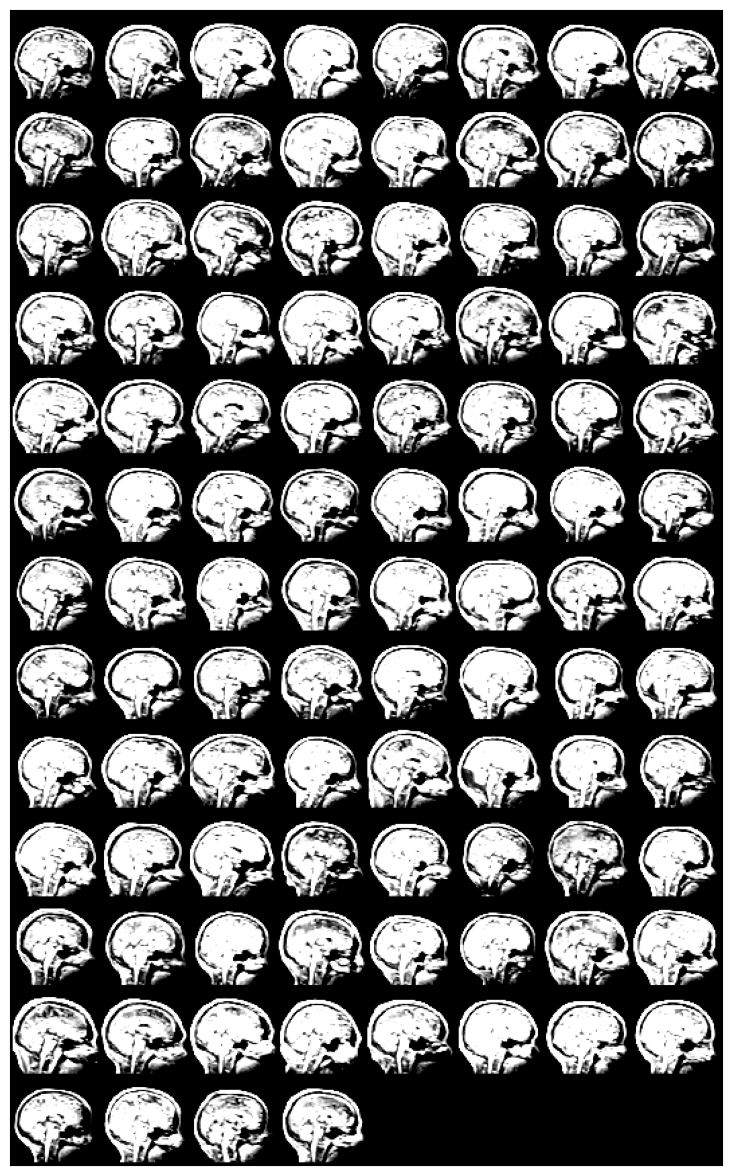

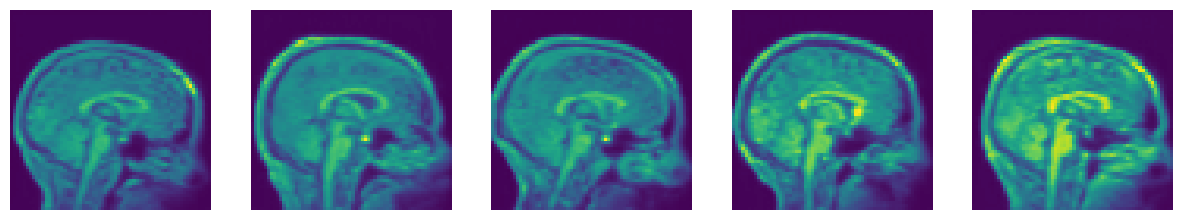

In [48]:
## Testing images saved correctly

# Load in saved imputed images
results = np.load('/content/drive/MyDrive/DL_CW_Data/model_outputs.npy')
print("shape", results.shape)


## Plot side by sides of test data and inference
fig.suptitle('Checking all 100 imputed samples', fontsize=20)

target_grid = make_grid(torch.from_numpy(results))

plt.figure(figsize=(10,15))
plt.imshow(target_grid.permute(1,2,0))
plt.xticks([])
plt.yticks([])
plt.show()

## Plot a couple samples

fig, axes = plt.subplots(1, 5, figsize=(15, 6))

for i in range(5):
  # Plot the test images
  axes[i].imshow(results[i* 5].squeeze(0))
  axes[i].axis("off")



### Paragraph explaining my design choice

### I have gone for a UNet for a few reasons. Firstly they are commonly used for denoising images and it is a generally lightweight architecture compared to others, which suits the amount of resources I have available in this task. Initally I found that my 10K model was becoming overfit at around 15 epochs. I tried to combat this by introducing dropout to the model but I found this increased the overall loss of my result too much so I insted of simplifying my model I decided to increase my dataset to 20K.